In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from clinical_evaluation.registration_tools import preprocess
from skimage.draw import disk
from pathlib import Path

In [2]:
# Load the phantom converted to nrrd and create folder to save the data
path = Path("/home/suraj/Repositories/data/NKI/phantoms/SmallConfig.nrrd")
folder = Path.cwd() / path.stem
folder = folder.resolve()
folder.mkdir(exist_ok=True, parents=True)

In [3]:
# Read the phantom, correct offset and mask the "body"
Phantom = sitk.ReadImage(str(path))
Phantom = preprocess.hu_correction(Phantom)
array = sitk.GetArrayFromImage(Phantom)
mask, bound = preprocess.get_body_mask_and_bound(array, HU_threshold=-700)
masked_array = np.where(mask, array, -1024)
phantom_image = sitk.GetImageFromArray(masked_array)
phantom_image.CopyInformation(Phantom)

In [4]:
BigConfig = {
    # Centers of each of the plugs
    "centers": {
          "x": [0.0, 5.0, 4.95, -0.1, -5.1, -5.1],
          "y": [+5.7, +2.7, -3.1, -6, -3.1, +2.8],
    },
    # Range of interest in the z-axis where the plugs are present
    "zrange": [-1.1, 1.3],
    # Radius to draw each plug mask 
    "radius": 13,
    # Names of the different plugs in the inserts
    "names": ['Air', 'LDPE', 'Polystyrene', 'Acrylic', 'Delrin', 'Teflon'],
    
    # values of the plugs, corrected by -1024
    "values": [v - 1024 for v in [24, 924, 989, 1144, 1364, 1974]],
    
    # Colors if needed to be plot
    "colors": ['r', 'g', 'b', 'w', 'y', 'cyan']

}

SmallConfig = {
    # Centers of each of the plugs
    "centers": {
         "x":  [-0.1, 4.9, 4.95, -0.3, -5.2, -5.2],
          "y": [+5.8, +2.8, -3, -5.9, -3, +2.8]
    },
    # Range of interest in the z-axis where the plugs are present
    "zrange": [-1.1, 1.3],
    # Radius to draw each plug mask 
    "radius": 13,
    # Names of the different plugs in the inserts
    "names": ['Air', 'LDPE', 'Polystyrene', 'Acrylic', 'Delrin', 'Teflon'],
    
    # values of the plugs, corrected by -1024
    "values": [v - 1024 for v in [24, 924, 989, 1144, 1364, 1974]],
    
    # Colors if needed to be plot
    "colors": ['r', 'g', 'b', 'w', 'y', 'cyan']

}

config = eval(path.stem)

print(f"Loaded config based on filename {path.stem}: \n {config}")

Loaded config based on filename SmallConfig: 
 {'centers': {'x': [-0.1, 4.9, 4.95, -0.3, -5.2, -5.2], 'y': [5.8, 2.8, -3, -5.9, -3, 2.8]}, 'zrange': [-1.1, 1.3], 'radius': 13, 'names': ['Air', 'LDPE', 'Polystyrene', 'Acrylic', 'Delrin', 'Teflon'], 'values': [-1000, -100, -35, 120, 340, 950], 'colors': ['r', 'g', 'b', 'w', 'y', 'cyan']}


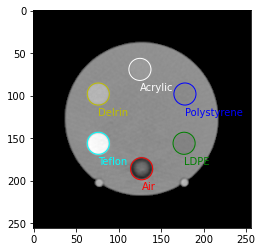

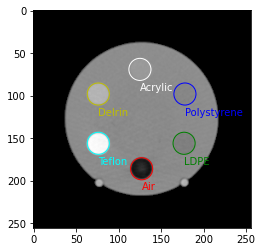

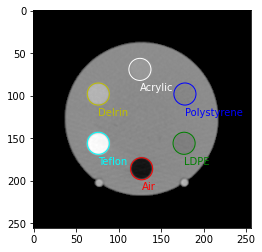

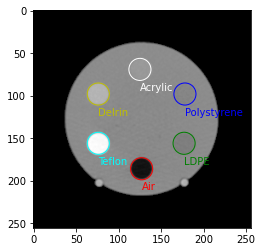

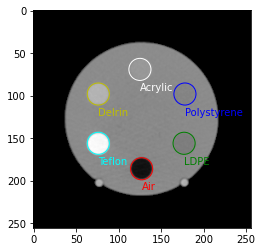

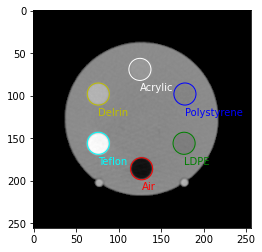

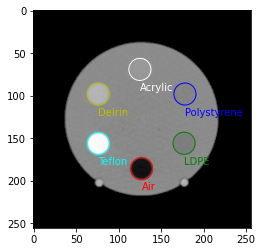

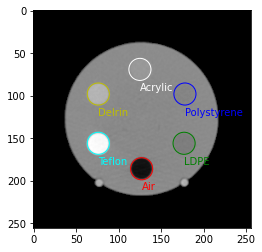

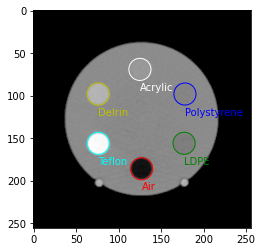

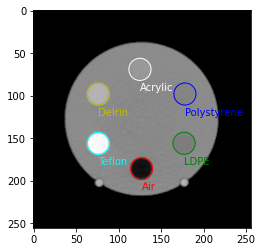

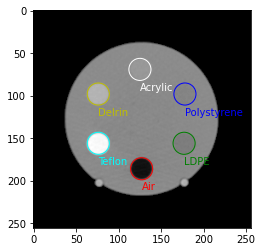

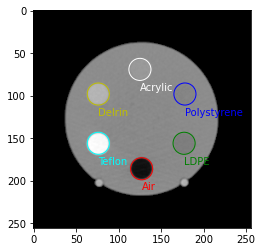

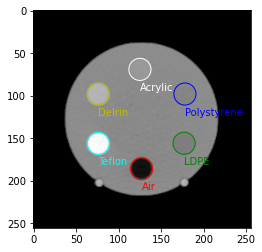

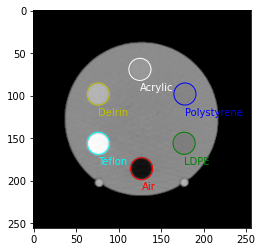

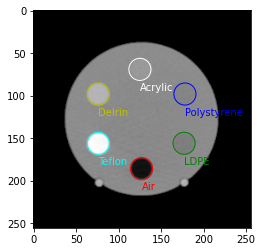

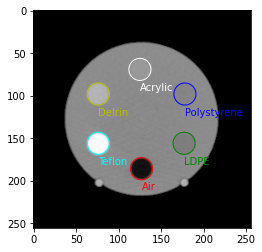

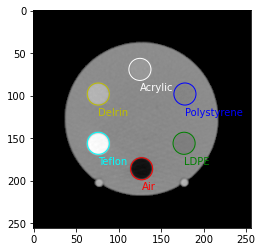

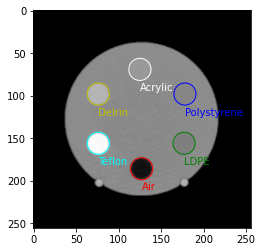

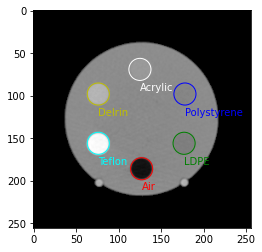

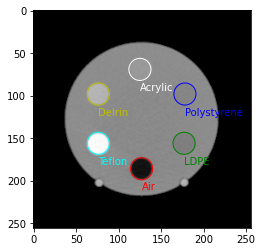

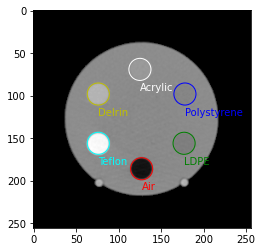

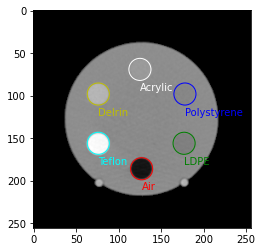

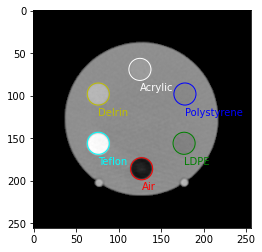

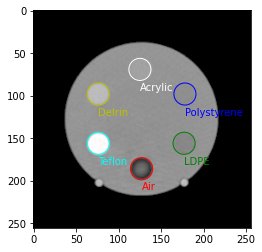

In [5]:
phantom_mask = {k: np.zeros(masked_array.shape, dtype=np.uint8) for k in config["names"]}
phantom_mask["plate"] = np.zeros(masked_array.shape, dtype=np.uint8)

array = sitk.GetArrayFromImage(phantom_image)
for j in range(0, phantom_image.GetSize()[-1]):
    
    # Get z coordinate in mm
    coord = phantom_image.TransformIndexToPhysicalPoint((0, 0, j))[-1] / 10
    if (coord > config["zrange"][0]) and (coord < config["zrange"][1]):
        
        plt.imshow(array[j], cmap='gray')
        phantom_mask["plate"][j] = np.where(mask[j], 1, 0)
        
        for i in range(0, len(config["names"])):
            # Get the center in mm 
            center = phantom_image.TransformPhysicalPointToIndex((config["centers"]["x"][i]*10, \
                                                                  config["centers"]["y"][i]*10, coord*10))[:-1]
            # Get circle rows and cols and set mask based on circle
            rr, cc = disk(center, config["radius"])
            phantom_mask[config["names"][i]][j, cc, rr] = 1
            phantom_mask["plate"][j, cc, rr] = 0
            
            # Plot the image for verification!
            circle = plt.Circle((center[0], center[1]), 13, color=config["colors"][i], fill=False, label=config["names"][i])
            circle = plt.Circle((center[0], center[1]), 13, color=config["colors"][i], fill=False, label=config["names"][i])
            plt.text(center[0], center[1] + 25, config["names"][i], color=config["colors"][i])
            plt.gca().add_patch(circle)
        plt.show()


In [6]:
phantom_image = sitk.Cast(phantom_image, sitk.sitkInt16)
sitk.WriteImage(phantom_image, str((folder / 'phantom').with_suffix('.nrrd')), True)